# Motion of particle in $1/r$ potential
In this notebook explicit expressions for the dynamics of a particle moving in a gravitational potential are derived. Two cases are considered:

* a non-relativistic particle moving in a $1/r$ central potential force field are derived. Explicit expressions for the trajectory are then implemented in the `KeplerSolution` class in [kepler.py](src/conservative_nn/kepler.py).
* a relativistic particle moving in the Schwarzschild metric

## Part I: non-relativistic dynamics
### Derivation of the Binet equation
Consider the motion in the following central potential

$$
U(r)=-\frac{\alpha}{r}.
$$

The total energy is given by

$$
E = T + U = \frac{1}{2}m\left(r^2\dot{\varphi}^2 + \dot{r}^2\right) - \frac{\alpha}{r}.
$$

with $\alpha>0$. Since the angular momentum $L=mr^2\dot{\varphi}$ is conserved, this leads to

$$
E = \frac{m}{2}\dot{r}^2 + \underbrace{\frac{L^2}{2m}\frac{1}{r^2} - \frac{\alpha}{r}}_{=:U_{\text{eff}}(r)}\qquad(\dagger)
$$

Introduce the new variable $u(\varphi) = 1/r(\varphi)$.

From the conservation of angular momentum it then follows that

$$
\dot{r} = -\frac{L}{m}\frac{du}{d\varphi}\qquad(\ddagger)
$$

and the energy equation in Eq. ($\dagger$) can be written as

$$
E = \frac{L^2}{2m}\left(\frac{du}{d\varphi}\right)^2 + \frac{L^2}{2m}u^2 - \alpha u
$$

taking the derivative $d/d\varphi$ of this equation then gives, after cancelling factors of $du/d\varphi$:

$$
\frac{d^2u}{d\varphi^2} + u = \frac{\alpha m}{L^2}
$$

This is also known as the [Binet equation](https://en.wikipedia.org/wiki/Binet_equation). The solution is

### Solution of the Binet equation

$$
u(\varphi) = \frac{\alpha m}{L^2}\left(1+\varepsilon_{\text{ex}}\cos(\varphi-\varphi_0)\right)\qquad(\star)
$$

or

$$
r(\varphi) = \frac{L^2}{\alpha m}\frac{1}{1+\varepsilon_{\text{ex}}\cos(\varphi-\varphi_0)}
$$

Here $0\le \varepsilon_{\text{ex}}<1$ is the excentricity. $\varepsilon_{\text{ex}}$ would correspond to circular motion.

### Time derivatives in polar coordinates

We further have that $\dot{r}=0$ for $\varphi=\varphi_0$ (and $\varphi=\varphi_0+n\pi$, $n\in\mathbb{Z}$). This allows relating total energy $E$, angular momentum $L$ and excentricity $\varepsilon_{\text{ex}}$ as follows:

$$
E = -\frac{\alpha^2m}{2L^2}\left(1-\varepsilon_{\text{ex}}^2\right)
$$

The time derivatives $r$ and $\varphi$ are obtained from Eqs. ($\star$), ($\ddagger$) and angular momentum conservation as

$$
\begin{aligned}
\dot{r} &= -\frac{L}{m}\frac{du}{d\varphi} = \frac{\alpha}{L}\varepsilon_{\text{ex}}\sin(\varphi-\varphi_0)\\
\dot{\varphi} &= \frac{L}{m}u^2 = \frac{\alpha^2 m}{L^3}\left(1+\varepsilon_{\text{ex}}\cos(\varphi-\varphi_0)\right)^2
\end{aligned}
$$

Further, for the second derivatives we get with the chain rule

$$
\begin{aligned}
\ddot{r} &= \frac{\alpha}{L}\varepsilon_{\text{ex}}\dot{\varphi}\cos(\varphi-\varphi)\\
&= \frac{\alpha^3 m}{L^4} \varepsilon_{\text{ex}} \left(1+\varepsilon_{\text{ex}}\cos(\varphi-\varphi_0)\right)^2\cos(\varphi-\varphi).
\end{aligned}
$$

### Position, velocity and acceleration in polar coordinates

With this, we can work out expressions for position $\boldsymbol{x}$ velocity $\boldsymbol{v}=\dot{\boldsymbol{x}}$ and acceleration $\boldsymbol{a}=\ddot{\boldsymbol{x}}$ in polar coordinates:

$$
\begin{aligned}
\boldsymbol{x} &= r\widehat{\boldsymbol{e}}_r\\
\dot{\boldsymbol{x}} &= \dot{r}\widehat{\boldsymbol{e}}_r + r\dot{\varphi}\widehat{\boldsymbol{e}}_\varphi\\
\ddot{\boldsymbol{x}} &= \left(\ddot{r}-r\dot{\varphi}^2\right)\widehat{\boldsymbol{e}}_r
\end{aligned}
$$

## Demonstration
Visualise some trajectories generated with the `KeplerSolution` class. Sample from the exact trajectories are compared to a numerical solution obtained with the RK4 timestepper.

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

from conservative_nn.time_integrator import RK4Integrator
from conservative_nn.dynamical_system import KeplerSystem
from conservative_nn.kepler import KeplerSolution

%matplotlib inline

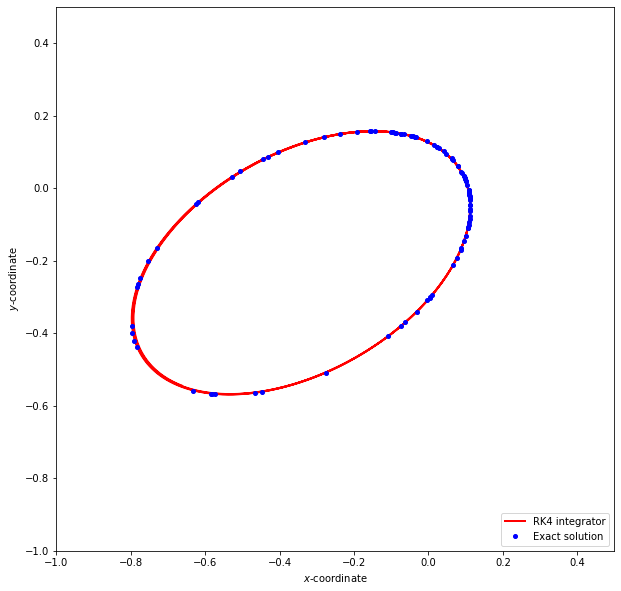

In [2]:
# Strength of 1/r potential
alpha = 1.0
# Mass of particle
mass = 1.0
# Excentricity of elliptic orbit
excentricity = 0.8
# Energy (must be negative)
energy = -1.0
# Initial angle
phi0=0.54
# Timestep size for numerical integrator
dt = 0.01
# Final time
t_final = 8.0

# Construct solution
kepler = KeplerSolution(mass=mass,alpha=alpha,excentricity=excentricity,energy=energy,phi0=phi0)
# Random collection of angles
Phi = np.random.uniform(low=-np.pi,high=+np.pi,size=100)
positions_exact = kepler.position(Phi)
velocities_exact = kepler.velocity(Phi)

q = positions_exact[:,0]
qdot = velocities_exact[:,0]

# Compute solution numerically.
dynamical_system = KeplerSystem(mass=mass,alpha=alpha)
time_integrator = RK4Integrator(dynamical_system,dt=dt)
time_integrator.set_state(q,qdot)

nsteps = int(t_final/dt)
q_all = np.zeros(shape=[nsteps+1,3])
for j in range(nsteps+1):
    q_all[j,:] = time_integrator.q[:]
    time_integrator.integrate(1)

# Visualise trajectories
plt.figure(figsize=(10,10))
plt.plot(q_all[:,0],q_all[:,1],linewidth=2,color="red",label="RK4 integrator")
plt.plot(positions_exact[0,:],positions_exact[1,:],marker='o',markersize=4,linewidth=0,color="blue",label="Exact solution")
ax = plt.gca()
ax.set_xlim(-1,+0.5)
ax.set_ylim(-1,+0.5)
ax.set_xlabel("$x$-coordinate")
ax.set_ylabel("$y$-coordinate")
plt.legend(loc="lower right")

## Part II: relativistic dynamics

### Schwarzschild metric
The Schwarzschild metric is given as follows in spherical coordinates:

$$
\begin{aligned}
ds^2 &= g_{\mu\nu}x^\mu x^\nu\\
&=-\left(1-\frac{r_s}{r}\right)(dx^0)^2 + \frac{1}{1-\frac{r_s}{r}}dr^2 + r^2 d\theta^2 + r^2\sin^2(\theta)d\varphi^2
\end{aligned}
$$

In the following, we always write $t$ for proper time and $x^\mu = (\tau,\boldsymbol{x})$ for the contravariant coordinates. We only consider the motion of a massive particle.

### Lagrangian
The Lagrangian can be defined as

$$
\begin{aligned}
L &= \left(\frac{ds}{dt}\right)^2 = g_{\mu\nu}\dot{x}^\mu\dot{x}^\nu\\
&= -\left(1-\frac{r_s}{r}\right)\dot{\tau}^2 + \left(1-\frac{r_s}{r}\right)^{-1}\dot{r}^2 + r^2\dot{\theta}^2 + r^2\sin^2(\theta)\dot{\varphi}^2.
\end{aligned}
$$

(note that this is results in the same equations of motion as defining $L=ds/dt$, but avoids a square root).

To express the spatial part of the Lagrangian in Cartesian coordinates, observe that

$$
\boldsymbol{x}\cdot\dot{\boldsymbol{x}} = \frac{d}{dt}\left(\frac{1}{2}\boldsymbol{x}\cdot\boldsymbol{x}\right) = \frac{d}{dt}\left(\frac{1}{2}r^2\right) = r\dot{r}\qquad\Rightarrow\qquad \dot{r}^2 = \frac{(\boldsymbol{x}\cdot\dot{\boldsymbol{x}})^2}{r^2}
$$

Since the spatial velocity in spherical coordinates is

$$
\dot{\boldsymbol{x}} = \dot{r}\widehat{\boldsymbol{e}}_r + r\dot{\theta}\widehat{\boldsymbol{e}}_\theta + r\sin(\theta)\dot{\varphi}\widehat{\boldsymbol{e}}_\varphi
$$

this implies that

$$
r^2 \dot{\theta}^2 + r^2 \sin^2(\theta)\dot{\varphi}^2 = \dot{\boldsymbol{x}}^2 - \frac{(\boldsymbol{x}\cdot\dot{\boldsymbol{x}})^2}{r^2}
$$

and hence the Lagrangian is given in Cartesian coordinates as

$$
L = -\left(1-\frac{r_s}{r}\right)\dot{\tau}^2 + \dot{\boldsymbol{x}}^2 + \frac{r_s}{r}\left(1-\frac{r_s}{r}\right)^{-1}\frac{(\boldsymbol{x}\cdot\dot{\boldsymbol{x}})^2}{r^2}
$$

### Solution
As for the non-relativistic particle, the vector-valued angular momentum is conserved, which implies that the motion is confined to a plane. The absolute value of the angular momentum is $L=mr^2\dot{\varphi}$ is also conserved, and we can write more generally for the *specific* angular momentum

$$
\frac{L}{m} = r^2\dot{\varphi} = |\boldsymbol{x}\times \dot{\boldsymbol{x}}|
$$

The equations of motion are written in polar coordinates for example [here](https://de.wikipedia.org/wiki/Schwarzschild-Metrik#Bewegungsgleichungen). The radial acceleration is

$$
\begin{aligned}
\ddot{r} = -\frac{r_s}{2r^2} + \left(r- \frac{3}{2}r_s\right)\dot{\varphi}^2.
\end{aligned}
$$

Using the fact that $\ddot{\boldsymbol{x}} = (\ddot{r}-r\dot{\varphi}^2)\widehat{\boldsymbol{e}}_r$ if the angular momentum is conserved, it is then easy to see that

$$
\begin{aligned}
\ddot{\boldsymbol{x}} &= -\frac{r_s}{2r^3}\left(1+3\frac{(\boldsymbol{x}\times\dot{\boldsymbol{x}})^2}{r^2}\right)\boldsymbol{x}\\
&= -\frac{r_s}{2r^3}\left(1+3\frac{\boldsymbol{x}^2\dot{\boldsymbol{x}}^2- (\boldsymbol{x}\cdot\dot{\boldsymbol{x}})^2}{r^2}\right)\boldsymbol{x}
\end{aligned}
$$

For the rate of change of the time coordinate $\tau$ we have

$$
\begin{aligned}
\ddot{\tau} &= -\frac{r_s}{r^2}\left(1-\frac{r_s}{r}\right)^{-1} \dot{r}\dot{\tau}\\
&= -\frac{r_s}{r}\left(1-\frac{r_s}{r}\right)^{-1} \frac{\boldsymbol{x}\cdot\dot{\boldsymbol{x}}}{r^2} \dot{\tau}
\end{aligned}
$$

### Four-velocity constraint
For a particle with mass the four velocity has to have a norm of $-1$ in the Schwarzschild metric. This implies that the four velocity $(\dot{\tau},\dot{\boldsymbol{x}})$ satisfies

$$
\left(1-\frac{r_s}{r}\right)\dot{\tau}^2 = 1+\frac{r_s}{r}\left(1-\frac{r_s}{r}\right)^{-1}\frac{(\boldsymbol{x}\cdot\dot{\boldsymbol{x}})^2}{r^2}+\dot{\boldsymbol{x}}^2
$$